## Unmasking biomacromolecular conformational dynamics from 2D analysis of subdomains vibration modes and molecular kinetics (Tutorial)

### Set up and exploratory analysis

In [16]:
#Importar librerias
import numpy as np
import MDAnalysis as mda

Using the library [`MDAnalysis`](https://www.mdanalysis.org/) it can be processed the _topology_ and the _trajectory_ of a simulation. The library has multiple atributes like as `.center_of_mass()`, `.radius_of_gyration()`

In [17]:
#Importar archivo .gro y trayectoria .xtc
u = mda.Universe('glyc_head\wt_0\md_nowater_noPBL.gro','glyc_head\wt_0\md_nowater_noPBL.xtc')
print(u, f'timesteps: {len(u.trajectory)}')
print(f'{u.atoms.center_of_mass()= }')
print(f'{u.atoms.center_of_geometry()= }')
print(f'{u.atoms.total_mass()= }')
print(f'{u.atoms.radius_of_gyration()= }')
print(f'{len(u.residues)=}')
print(f'Example of residues {u.residues[3]}, {u.residues.atoms=}')

<Universe with 3171 atoms> timesteps: 1501
u.atoms.center_of_mass()= array([42.38299487, 36.75692911, 53.46386281])
u.atoms.center_of_geometry()= array([42.4868106 , 36.73747887, 53.48104006])
u.atoms.total_mass()= 23053.647999999997
u.atoms.radius_of_gyration()= 18.567714060427203
len(u.residues)=200
Example of residues <Residue LEU, 4>, u.residues.atoms=<AtomGroup with 3171 atoms>


For the multiple domain analysis, in this example we choose residues for the SARS-CoV-2 spike simulation

In [21]:
#Select domain
domain_group1 = u.select_atoms('resid 4:15 or resid 34:45') #resid residue-number-range (inclusive)
domain_group2 = u.select_atoms('resid 104:117 or resid 170:176')
domain_glycan = u.select_atoms('resid 193:200')
domain = domain_glycan #single domain
# domain = domain_glycan+domain_group1+domain_group2 #multiple domain
print(f'{u.trajectory=}\nAtoms in domain selected: {len(domain_group1.atoms)+len(domain_group2.atoms)+len(domain_glycan.atoms)}')

u.trajectory=<XTCReader glyc_head\wt_0\md_nowater_noPBL.xtc with 1501 frames of 3171 atoms>
Atoms in domain selected: 844



In this step, the data is reordered by the following structure

$$
\mathbf{X} = \begin{pmatrix}
| & | & \cdots & | & |  \\
\mathbf{x^{(1)}} & \mathbf{x^{(2)}}  & \cdots & \mathbf{x^{(n-2)}} & \mathbf{x^{(n-1)}}  \\
| & | & \cdots & | & |
\end{pmatrix}
$$

Where $\mathbf{x}^{(1)}$ correspond to the initial time of the trajectory where all the coordinates are reordered in the column vector

In [19]:
#Create trajectory matrix
nt = 1501 # 1501 timesteps
X1 = np.zeros((len(domain)*3,nt)) #Trajectory matrix
for nt_step in u.trajectory:
    X1[:,nt_step.frame] = np.reshape(domain_glycan.positions,-1) # [x1,y1,z1,x2,y2,z2,...] can be improved!
[U,S,Vh] = np.linalg.svd(X1,full_matrices=False) #svd 

A preliminary tool is the Principal Component Analysis (PCA)

PCA is a dimensionality reduction machine learning method that can give a r-dimensional space where most of the variance of the trajectory is retained. The method can be formulated by different ways, a example is with the SVD decomposition for the matrix $\mathbf{X}$
$$
\mathbf{X} = U\Sigma V^{T}
$$
The columns of $U$ gives the principal components ordered decreasingly by variance, $\Sigma$ describe how important is a given principal component to the global variance of the trajectory, with that we analyse how many $r$ PC we have to retain to keep _most_ of the variance of the trajectory, and what are the PC that describes a low-dimensional space of the trajectory.

The PC are orthonormal, so the following identity is satisfied
$$
U^{T}U = UU^{T} = I
$$

First 10 singular values scaled: [76.14313118  4.89874733  1.84777124  1.25056613  0.93415179  0.79645498
  0.63601702  0.47751079  0.41478822  0.3979071 ]
sum of variance 10 values 87.80
Orthonormality check (for U) 1.0000


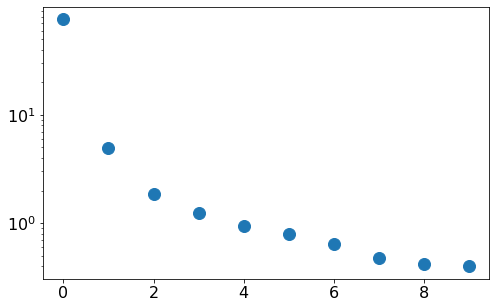

In [7]:
r=10 #number of Principal components (or spatial modes) retained

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.size'] = 16
plt.figure(figsize=(8,5))
S_scaled = 100*S/np.sum(S)
plt.plot(S_scaled[:r],'o',markersize=12)
plt.yscale('log')
print(f'First {r} singular values scaled: {S_scaled[:r]}')
print(f'sum of variance {r} values {np.sum(S_scaled[:r]):.2f}')
print(f'Orthonormality check (for U) {np.linalg.det(U[:,:r].T@U[:,:r]):.4f}')

To get a grasp of the data we can see two PC plotted in a scatter plot, where it can be identified the most density state on the trajectory for example

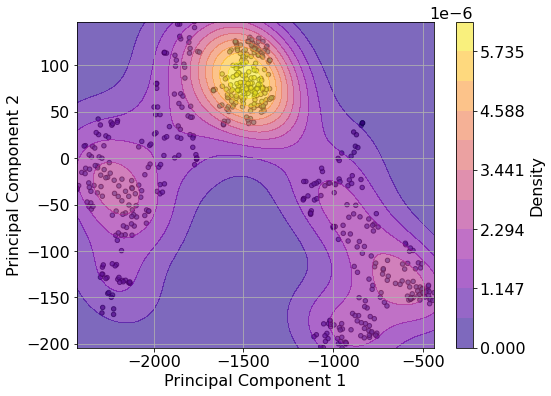

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Example data: First two principal components
PC1 = S[0] * U[:, 0]
PC2 = S[1] * U[:, 1]

# Perform kernel density estimation
xy = np.vstack([PC1, PC2])  # Stack PC1 and PC2
kde = gaussian_kde(xy)      # Kernel Density Estimation

# Define a grid for contour plotting
x_grid, y_grid = np.meshgrid(
    np.linspace(PC1.min(), PC1.max(), 100),
    np.linspace(PC2.min(), PC2.max(), 100)
)
grid_coords = np.vstack([x_grid.ravel(), y_grid.ravel()])
density = kde(grid_coords).reshape(x_grid.shape) #/np.sum(density.reshape(-1))

# Plot the scatter with filled density contours
plt.figure(figsize=(8, 6))
plt.scatter(PC1, PC2, c=kde(xy), cmap='viridis', alpha=0.7, edgecolor='k', s=20)
# Add filled contours
contour_levels = np.linspace(density.min(), density.max(), 12)  # Adjust levels for detail
plt.contourf(x_grid, y_grid, density, levels=contour_levels, cmap='plasma', alpha=0.6)

# Add color bar and labels
cbar = plt.colorbar()
cbar.set_label('Density')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


To apply Dynamic Mode Decomposition (DMD) [(Schmid 2010](https://doi.org/10.1017/S0022112010001217)[; Tu et al. 2014;](doi.org/10.3934/jcd.2014.1.391)[ Williams et al. 2015)](doi.org/10.1007/s00332-015-9258-5) to the trajectory data, the data is reordered with the follow structure
$$
\mathbf{X} = \begin{pmatrix}
| & | & \cdots & | & |  \\
\mathbf{x^{(1)}} & \mathbf{x^{(2)}}  & \cdots & \mathbf{x^{(n-2)}} & \mathbf{x^{(n-1)}}  \\
| & | & \cdots & | & |
\end{pmatrix}
$$

$$
\mathbf{X'} = \begin{pmatrix}
| & | & \cdots & | & |  \\
\mathbf{x^{(2)}} & \mathbf{x^{(3)}}  & \cdots & \mathbf{x^{(n-1)}} & \mathbf{x^{(n)}}  \\
| & | & \cdots & | & |
\end{pmatrix}
$$

Where $\mathbf{x}^(j)$ correspond to the $j$ instant in time where all the coordinates of the atoms are stacked in the vector array. The assumption is that the data follows the relation

$$
\mathbf{X'} = A\mathbf{X}
$$

The method search the matrix $A$ that fits the model better. There are many different extensions of the DMD model, that can be find in the papers above. In practice, the state is predicted using the dynamical modes $\mathbf{\Phi}$ and the eigenvalues $\mathbf{\Lambda}$ that comes from the matrix $A$ and a $\mathbf{b_0}$ constant is fitted given a initial condition. The prediction for the trajectories at time $k$
$$
\hat{\mathbf{X}^{k}} = \mathbf{\Phi}\mathbf{\Lambda}^{k}\mathbf{b_0}
$$

In the following sections, we will explore the main ideas of DMD applications for the trajectory

### DMD: Full trajectories (Single domain)

In [1]:
#Importar librerias
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
from matplotlib import rcParams
from MDAnalysis.analysis import rms, align

c:\Users\ianad\anaconda3\envs\bempp\lib\site-packages\Bio\Application\__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


As previosly explained, we apply DMD on the trajectory data of the simulation we rely on the library [`PyDMD`](https://github.com/PyDMD/PyDMD) ([Demo et al. 2018](https://joss.theoj.org/papers/10.21105/joss.00530)[Ichinaga et al. 2024](https://arxiv.org/abs/2402.07463)). We rearrange the trajectory data to the format explained as a input to the `PyDMD` library

c:\Users\ianad\anaconda3\envs\bempp\lib\site-packages\pydmd\bopdmd.py:812: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


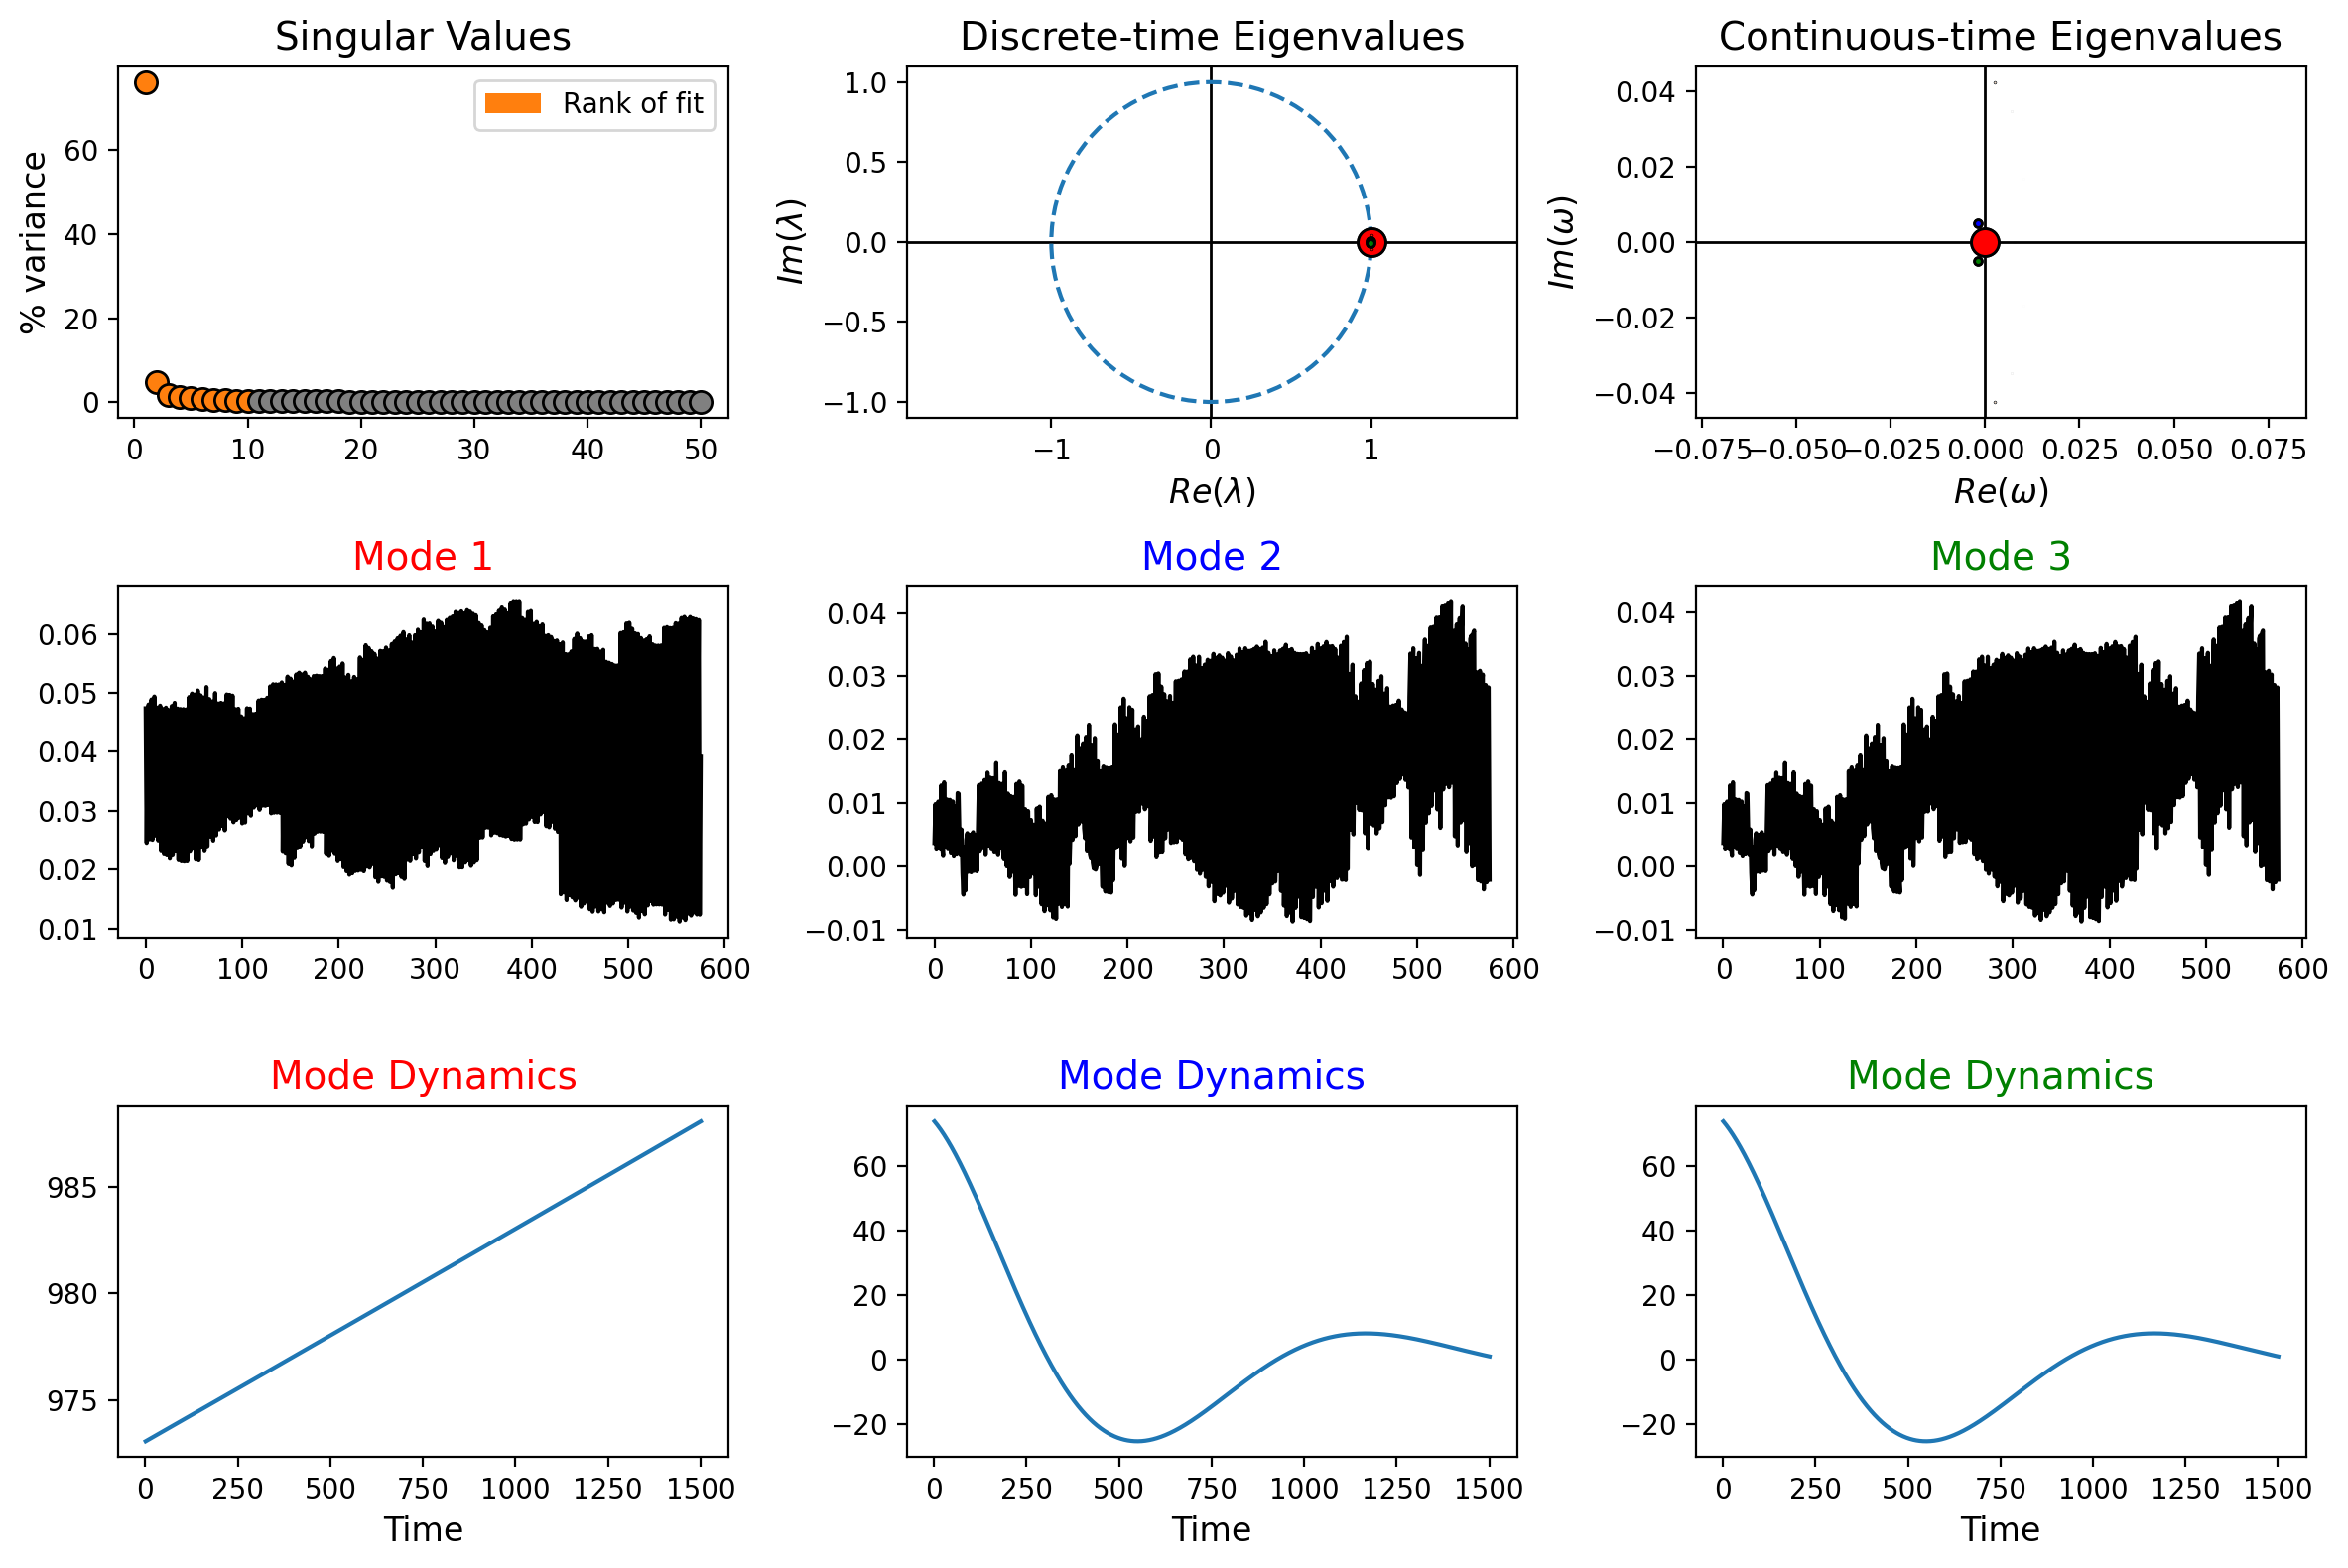

In [2]:
u = mda.Universe('glyc_head\wt_0\md_nowater_noPBL.gro','glyc_head\wt_0\md_nowater_noPBL.xtc')
#Select domain
domain_group1 = u.select_atoms('resid 4:15 or resid 34:45') #resid residue-number-range (inclusive)
domain_group2 = u.select_atoms('resid 104:117 or resid 170:176')
domain_glycan = u.select_atoms('resid 193:200')
#Create trajectory matrix
domain=domain_glycan
nt = 1501 # 1501 timesteps
r=10 #number of modes retained
X1 = np.zeros((len(domain)*3,nt)) #Trajectory matrix
for nt_step in u.trajectory:
    X1[:,nt_step.frame] = np.reshape(domain.positions,-1) # [x1,y1,z1,x2,y2,z2,...] can be improved!

from pydmd import DMD, BOPDMD, EDMD
from pydmd.plotter import plot_eigs, plot_summary
%matplotlib inline

# Build the Optimized DMD model.
t = np.linspace(1,nt,nt)
optdmd = BOPDMD(svd_rank=r)#, varpro_opts_dict={"verbose": True, "tol": 0.04}) #uncomment to add options
#dmd = DMD(svd_rank=4)
optdmd.fit(X1, t)
# Plot a summary of the DMD results.
plot_summary(optdmd)

In comparison to deep learning methods, the results here are interpretable. Specifically, Mode 1 refers to a spatial mode, following the format of the trajectory matrix: $(x_1, y_1, z_1, x_2, y_2, z_2, \dots, x_n, y_n, z_n)$. The mode dynamics are related to the eigenvalues obtained. Simply put, the real part of the eigenvalue indicates the growth of the mode over time, while the imaginary part describes the _oscillations_ of the mode in the dynamics.

In [3]:
domain.atoms.write('glyc_head\\wt_10\\domain_DMD.gro') #write gro from domain

#create .xtc for dmd reconstructed trajectory
n_atoms = len(domain)
# Reshape X1 to [n_timesteps, n_atoms, 3]
X1_reshaped = np.real(optdmd.reconstructed_data).T.reshape(nt, n_atoms, 3)  # Transpose and reshape
with mda.coordinates.XTC.XTCWriter('glyc_head\wt_10\md_nowater_noPBL_DMD.xtc', n_atoms=n_atoms) as writer:
    for idx,frame in enumerate(X1_reshaped):
        domain.positions = frame  # Update positions for the atoms in the selection
        writer.write(domain)  # Write the frame (positions and time) to the trajectory

with mda.coordinates.XTC.XTCWriter('glyc_head\wt_10\md_nowater_noPBL_DMD_ref.xtc', n_atoms=n_atoms) as writer:
    for idx,frame in enumerate(X1_reshaped):
        domain.positions = frame # Update positions for the atoms in the selection
        writer.write(domain)  # Write the frame (positions and time) to the trajectory
        break


c:\Users\ianad\anaconda3\envs\bempp\lib\site-packages\MDAnalysis\coordinates\XDR.py:241: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "
c:\Users\ianad\anaconda3\envs\bempp\lib\site-packages\MDAnalysis\analysis\rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


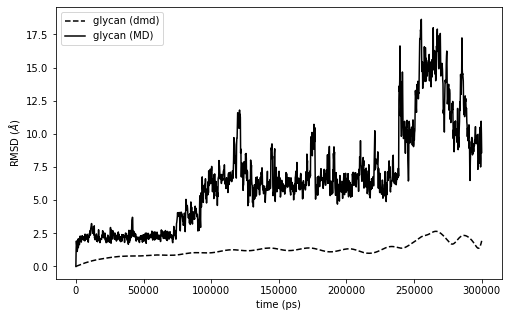

In [4]:
u_dmd = mda.Universe('glyc_head\wt_10\domain_DMD.gro','glyc_head\wt_10\md_nowater_noPBL_DMD.xtc')
u_dmd_ref = mda.Universe('glyc_head\wt_10\domain_DMD.gro','glyc_head\wt_10\md_nowater_noPBL_DMD_ref.xtc')

#Create plot RMSD DMD
aligner = align.AlignTraj(u_dmd, u_dmd_ref, select='resid 193:200', in_memory=True)
aligner.run()
R = mda.analysis.rms.RMSD(u_dmd, u_dmd_ref)              
R.run()
rmsd_dmd = R.rmsd.T   
#Create plot RMSD original
aligner = align.AlignTraj(u, u, select='resid 193:200', in_memory=True)
aligner.run()
R = mda.analysis.rms.RMSD(u, u, groupselections=["resid 4:15 or resid 34:45",       # GROUP1 idx3
                                              "resid 104:117 or resid 170:176",  # GROUP2 idx4
                                              "resid 193:200"], ref_frame=0)     # glycan idx5
R.run()
rmsd = R.rmsd.T   # transpose makes it easier for plotting

#Plot
fig = plt.figure(figsize=(8,5))
plt.plot(rmsd[0]*u.coord.dt, rmsd_dmd[2], 'k--',  label="glycan (dmd)"); 
plt.plot(rmsd[1], rmsd[5], 'k',  label="glycan (MD)");
plt.legend(loc="best"); plt.xlabel("time (ps)"); plt.ylabel(r"RMSD ($\AA$)");

Text(0.5, 0.98, 'Timestep 0.0')

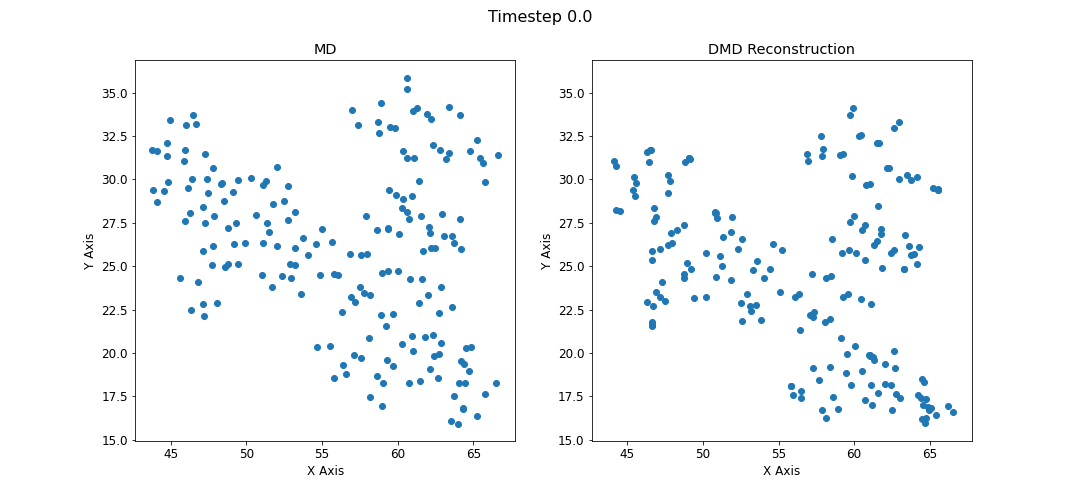

In [5]:
timestep = 0
X_traj_dmd = optdmd.reconstructed_data.reshape(len(domain_glycan),3,nt)
X_traj = X1.reshape(len(domain_glycan),3,nt) 
%matplotlib widget

rcParams['font.size'] = 12
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7))
ax1.scatter(np.real(X_traj[:,0,timestep]),np.real(X_traj[:,1,timestep]))
ax1.set_title('MD'); ax1.set_xlabel('X Axis'); ax1.set_ylabel('Y Axis')

ax2.scatter(np.real(X_traj_dmd[:,0,timestep]),np.real(X_traj_dmd[:,1,timestep]))
ax2.set_title('DMD Reconstruction'); ax2.set_xlabel('X Axis'); ax2.set_ylabel('Y Axis')
ax2.set_xlim(ax1.get_xlim()); ax2.set_ylim(ax1.get_ylim())

fig.suptitle(f'Timestep {rmsd[0,timestep]}', fontsize=16)

#### Create animation (optional)

In [221]:
X_traj = X1.reshape(len(domain_glycan),3,nt) #(n_atoms, axis, nt)
X_traj_dmd = optdmd.reconstructed_data.reshape(len(domain_glycan),3,nt)
timestep = 20
import matplotlib.pyplot as plt
import os
%matplotlib widget



for j in range(0,nt,timestep):
    fig = plt.figure(figsize=plt.figaspect(1)*1.5)
    ax = fig.add_subplot(projection='3d', proj_type='ortho')
    ax.scatter(X_traj[:,0,j],X_traj[:,1,j],X_traj[:,2,j])
    ax.set_xlabel('X Axis'); ax.set_ylabel('Y Axis'); ax.set_zlabel('Z Axis')
    ax.set_xlim([40,60]); ax.set_ylim([5,50]); ax.set_zlim([30,50])
    ax.view_init(elev=27, azim=-43)
    if not os.path.exists('glyc_head\wt_0\original'):
        os.mkdir('glyc_head\wt_0\original')
    plt.savefig(f'glyc_head\wt_0\original\plot_{j:05d}.png')
    plt.close()

for j in range(0,nt,timestep):
    # Create a new figure and set it to be 3D
    fig = plt.figure(figsize=plt.figaspect(1)*1.5)
    ax = fig.add_subplot(projection='3d', proj_type='ortho')
    ax.scatter(np.real(X_traj_dmd[:,0,j]),np.real(X_traj_dmd[:,1,j]),np.real(X_traj_dmd[:,2,j]))
    # Labels for the axes
    ax.set_xlabel('X Axis'); ax.set_ylabel('Y Axis'); ax.set_zlabel('Z Axis')
    ax.set_xlim([40,60]); ax.set_ylim([5,50]); ax.set_zlim([30,50])
    ax.view_init(elev=27, azim=-43)
    if not os.path.exists('glyc_head\wt_0\dmd'):
        os.mkdir('glyc_head\wt_0\dmd')
    plt.savefig(f'glyc_head\wt_0\dmd\plot_{j:05d}.png')
    plt.close()

### DMD: Full trajectories (Multiple domains)

In [1]:
#Importar librerias
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
from matplotlib import rcParams
from MDAnalysis.analysis import rms, align
from MDAnalysis.analysis.rms import RMSF

c:\Users\ianad\anaconda3\envs\bempp\lib\site-packages\Bio\Application\__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


As previosly explained, we apply DMD on the trajectory data of the simulation we rely on the library [`PyDMD`](https://github.com/PyDMD/PyDMD) ([Demo et al. 2018](https://joss.theoj.org/papers/10.21105/joss.00530)[Ichinaga et al. 2024](https://arxiv.org/abs/2402.07463)). We rearrange the trajectory data to the format explained as a input to the `PyDMD` library

Here we focus in GROUP1, GROUP2 and glycan of the simulation

c:\Users\ianad\anaconda3\envs\bempp\lib\site-packages\pydmd\snapshots.py:73: UserWarning: Input data condition number 141056.28427817946. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
c:\Users\ianad\anaconda3\envs\bempp\lib\site-packages\pydmd\bopdmd.py:812: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


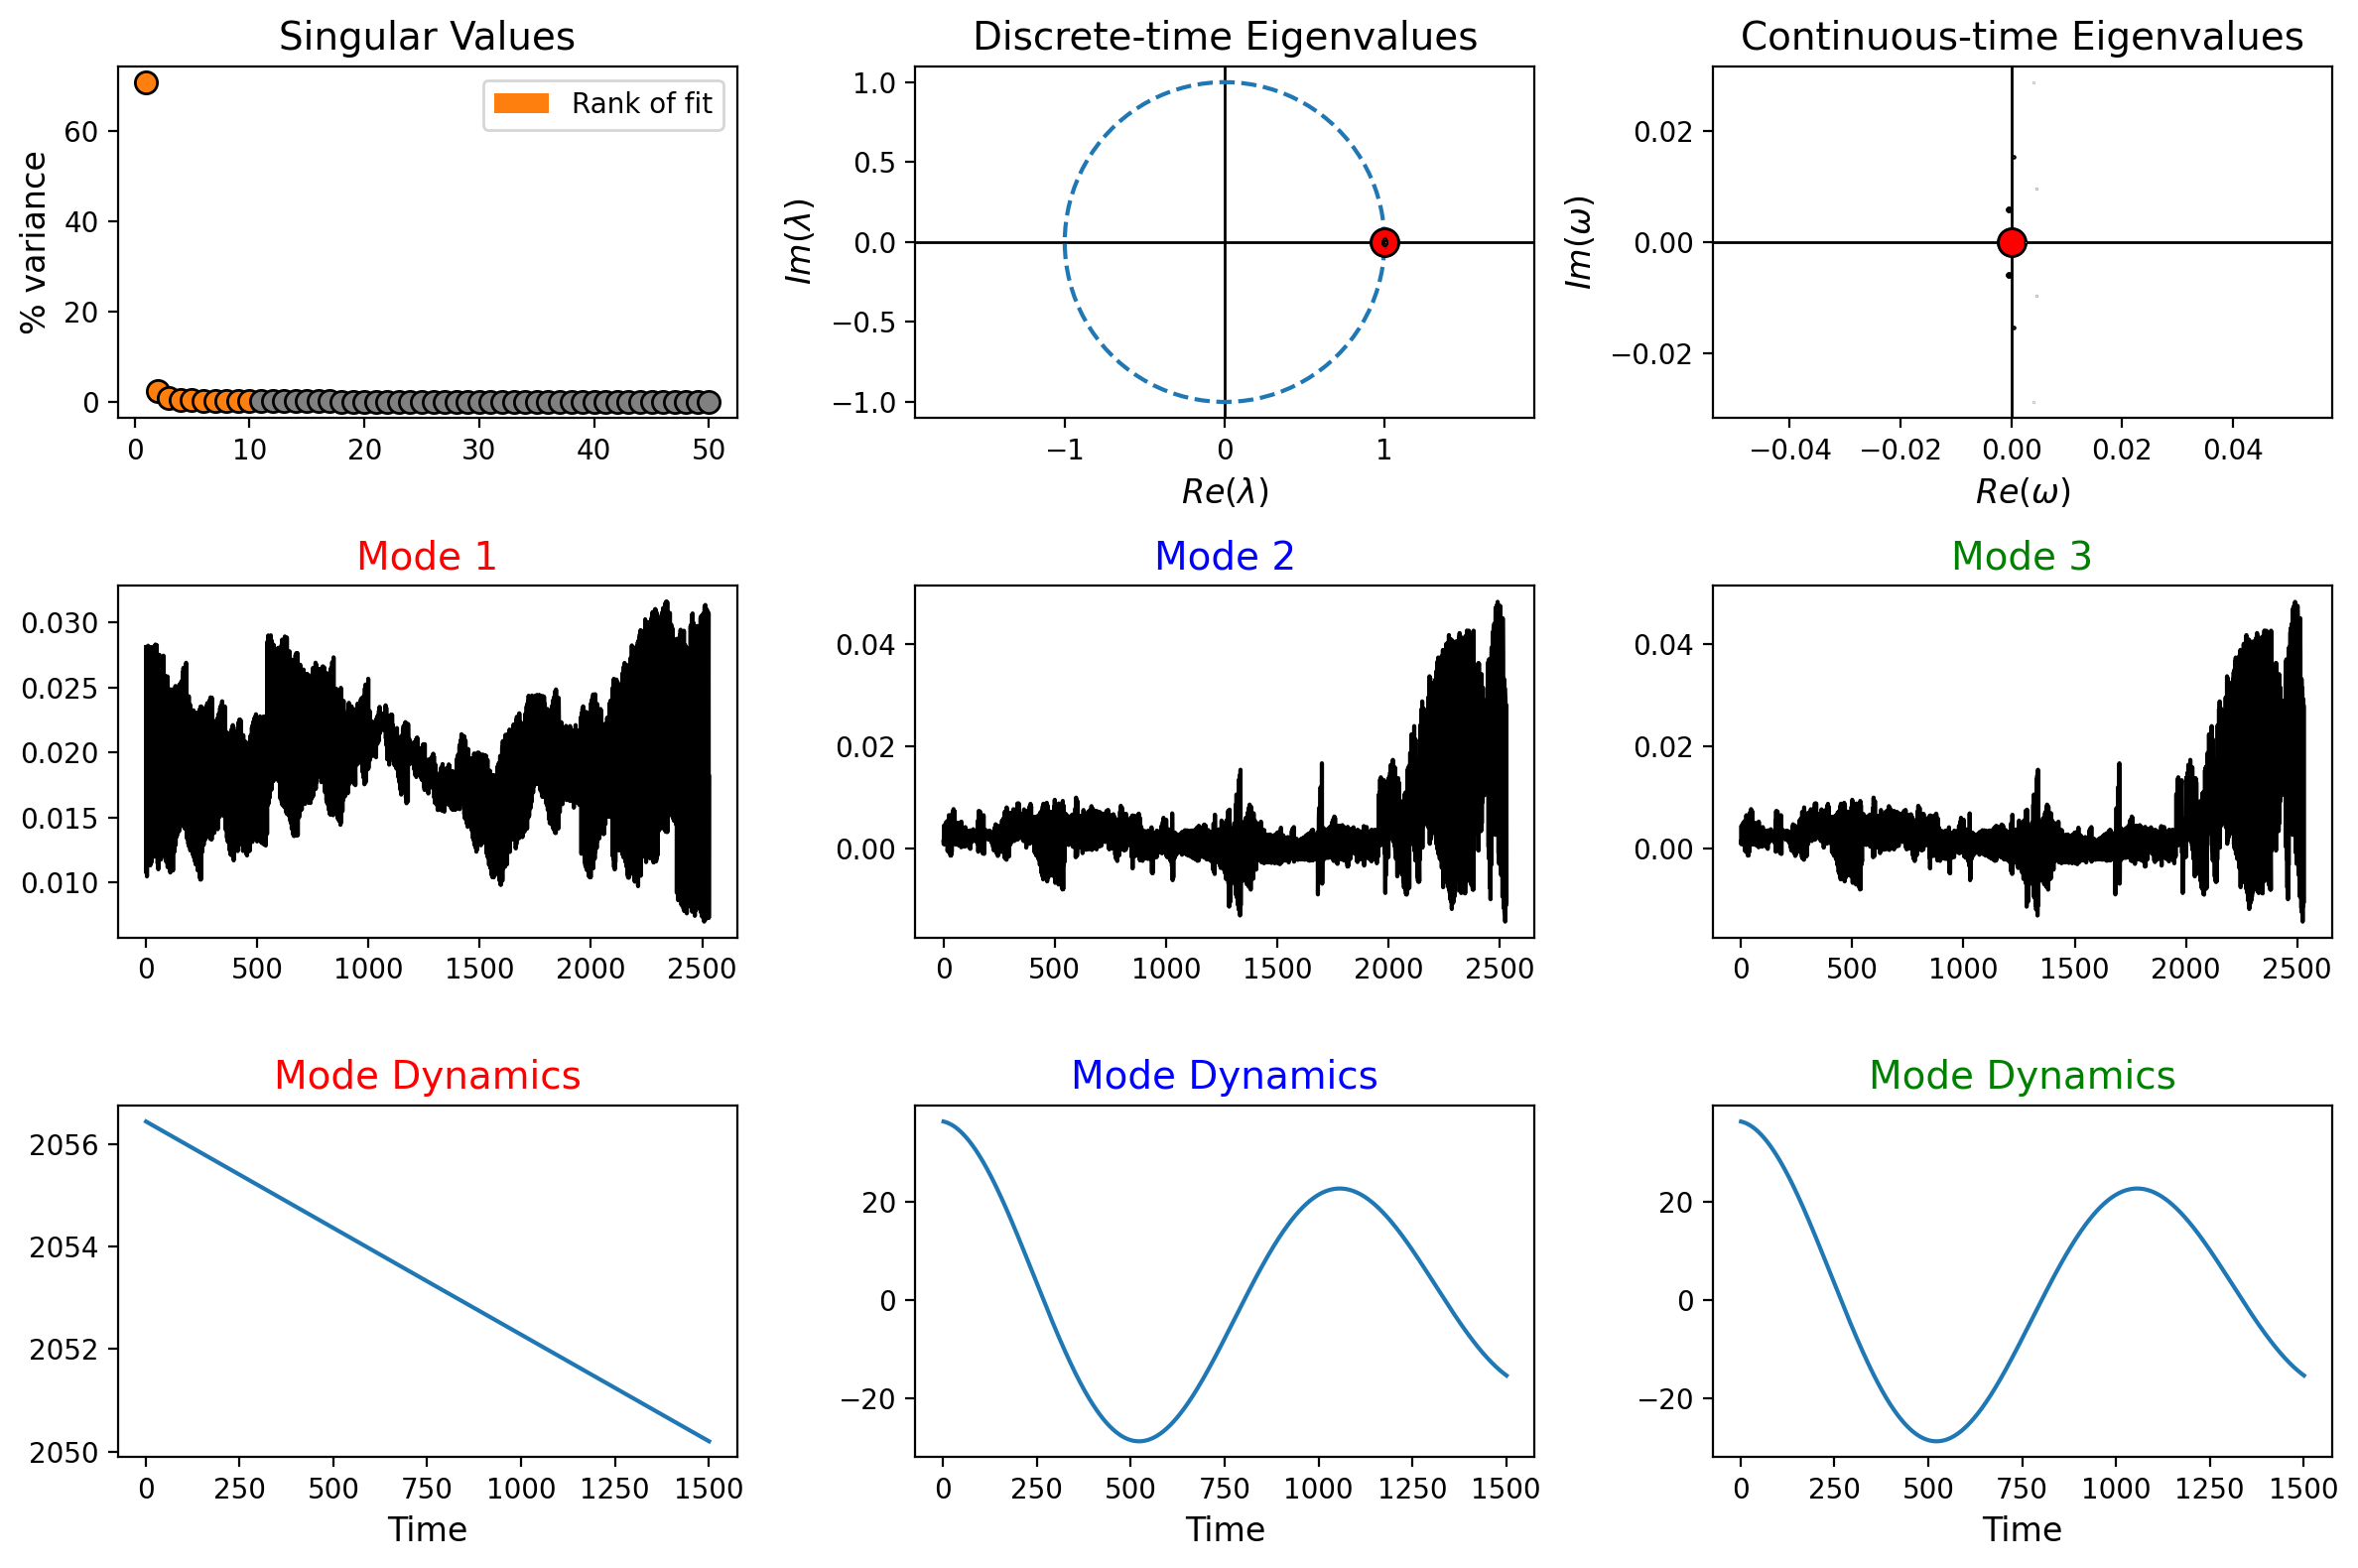

In [2]:
u = mda.Universe('glyc_head\wt_0\md_nowater_noPBL.gro','glyc_head\wt_0\md_nowater_noPBL.xtc')
#Select domain
domain_group1 = u.select_atoms('resid 4:15 or resid 34:45') #resid residue-number-range (inclusive)
domain_group2 = u.select_atoms('resid 104:117 or resid 170:176')
domain_glycan = u.select_atoms('resid 193:200')
r=10
domain = domain_group1+domain_group2+domain_glycan
#Create trajectory matrix
nt = 1501 # 1501 timesteps
X1 = np.zeros((domain.n_atoms*3,nt)) #Trajectory matrix
for nt_step in u.trajectory:
    X1[:,nt_step.frame] = np.reshape(domain.positions,-1) # [x1,y1,z1,x2,y2,z2,...] can be improved!

from pydmd import DMD, BOPDMD, EDMD
from pydmd.plotter import plot_eigs, plot_summary
%matplotlib inline

# Build the Optimized DMD model.
t = np.linspace(1,nt,nt)
optdmd = BOPDMD(svd_rank=r)#, varpro_opts_dict={"verbose": True, "tol": 0.04}) #uncomment to add options
#dmd = DMD(svd_rank=4)
optdmd.fit(X1, t)

# Plot a summary of the DMD results.
plot_summary(optdmd)

c:\Users\ianad\anaconda3\envs\bempp\lib\site-packages\MDAnalysis\analysis\rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


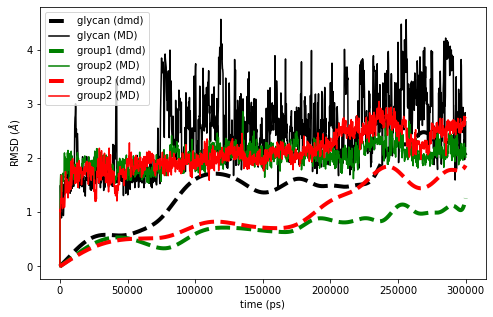

In [4]:
#create .xtc for dmd reconstructed trajectory
n_atoms = len(domain)
# Reshape X1 to [n_timesteps, n_atoms, 3]
X1_reshaped = np.real(optdmd.reconstructed_data).T.reshape(nt, n_atoms, 3)  # Transpose and reshape

rmsd_dmd = {}
rmsd = {}
dict_domain = {'group1':'resid 4:15 or resid 34:45', 
               'group2': 'resid 104:117 or resid 170:176',
               'glycan':'resid 193:200'}
for key,value in dict_domain.items():
    domain_dmd = mda.Merge(domain).load_new(
            X1_reshaped[:, :, :], order="fac") #frame atom coordinate
    aligner = align.AlignTraj(domain_dmd, domain_dmd, select=value, in_memory=True)
    aligner.run()
    R = mda.analysis.rms.RMSD(domain_dmd, domain_dmd, select=value, ref_frame=0)              
    R.run()
    rmsd_dmd[key] = R.rmsd.T

for key,value in dict_domain.items():
    u = mda.Universe('glyc_head\wt_0\md_nowater_noPBL.gro','glyc_head\wt_0\md_nowater_noPBL.xtc')
    aligner = align.AlignTraj(u, u, select=value, in_memory=True)
    aligner.run()
    R = mda.analysis.rms.RMSD(u, u, select=value, ref_frame=0)              
    R.run()
    rmsd[key] = R.rmsd.T 

#Plot
fig = plt.figure(figsize=(8,5))
plt.plot(rmsd['glycan'][0]*u.coord.dt, rmsd_dmd['glycan'][2], 'k--',  label="glycan (dmd)",linewidth=4); 
plt.plot(rmsd['glycan'][1], rmsd['glycan'][2], 'k',  label="glycan (MD)");
plt.plot(rmsd['group1'][0]*u.coord.dt, rmsd_dmd['group1'][2], 'g--',  label="group1 (dmd)",linewidth=4); 
plt.plot(rmsd['group1'][1], rmsd['group1'][2], 'g',  label="group2 (MD)");
plt.plot(rmsd['group2'][0]*u.coord.dt, rmsd_dmd['group2'][2], 'r--',  label="group2 (dmd)",linewidth=4); 
plt.plot(rmsd['group2'][1], rmsd['group2'][2], 'r',  label="group2 (MD)");
plt.legend(loc="best"); plt.xlabel("time (ps)"); plt.ylabel(r"RMSD ($\AA$)");

In [5]:
rmsf_dmd = {}
rmsf = {}
dict_domain = {'group1':'resid 4:15 or resid 34:45', 
               'group2': 'resid 104:117 or resid 170:176',
               'glycan':'resid 193:200'}
for key,value in dict_domain.items(): #Based on MDAnalysis script
    domain_dmd = mda.Merge(domain).load_new(
            X1_reshaped[:, :, :], order="fac") #frame atom coordinate
    selection = domain_dmd.select_atoms(value)
    reference_coordinates = domain_dmd.trajectory.timeseries(asel=selection).mean(axis=1)
    reference = mda.Merge(selection).load_new(
                reference_coordinates[:, None, :], order="afc")           
    aligner = align.AlignTraj(domain_dmd, reference, select=value, in_memory=True).run()
    rmsf_dmd[key] = RMSF(selection, verbose=True).run()

for key,value in dict_domain.items(): #Based on MDAnalysis script
    u = mda.Universe('glyc_head\wt_0\md_nowater_noPBL.gro','glyc_head\wt_0\md_nowater_noPBL.xtc', in_memory=True)
    selection = u.select_atoms(value)
    reference_coordinates = u.trajectory.timeseries(asel=selection).mean(axis=1)
    reference = mda.Merge(selection).load_new(
                reference_coordinates[:, None, :], order="afc")           
    aligner = align.AlignTraj(u, reference, select=value, in_memory=True).run()
    rmsf[key] = RMSF(selection, verbose=True).run()

  0%|          | 0/1501 [00:00<?, ?it/s]

  0%|          | 0/1501 [00:00<?, ?it/s]

  0%|          | 0/1501 [00:00<?, ?it/s]

  0%|          | 0/1501 [00:00<?, ?it/s]

  0%|          | 0/1501 [00:00<?, ?it/s]

  0%|          | 0/1501 [00:00<?, ?it/s]

c:\Users\ianad\anaconda3\envs\bempp\lib\site-packages\MDAnalysis\analysis\rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


Text(0.5, 1.0, 'Glycan (MD)')

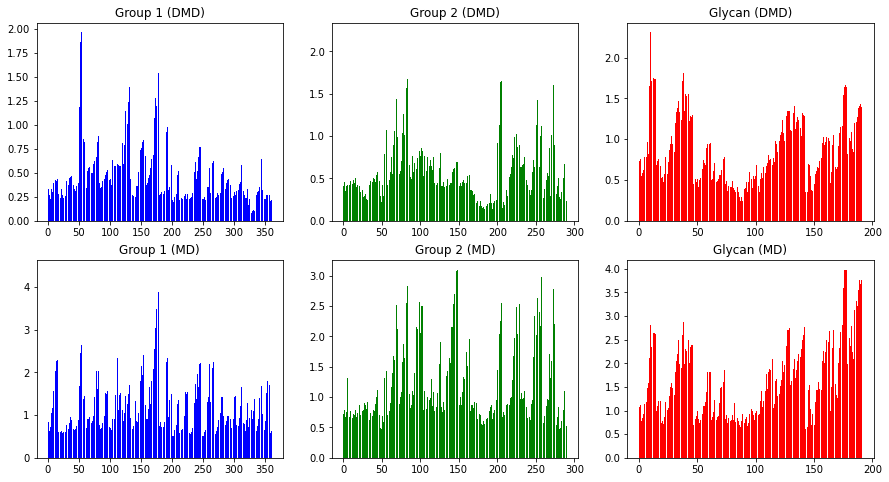

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(15,8))
axs[0,0].bar(range(len(domain_dmd.select_atoms(dict_domain['group1']))), rmsf_dmd['group1'].rmsf,color='b')
axs[0,1].bar(range(len(domain_dmd.select_atoms(dict_domain['group2']))), rmsf_dmd['group2'].rmsf,color='g')
axs[0,2].bar(range(len(domain_dmd.select_atoms(dict_domain['glycan']))), rmsf_dmd['glycan'].rmsf,color='r')
axs[1,0].bar(range(len(domain.select_atoms(dict_domain['group1']))), rmsf['group1'].rmsf,color='b')
axs[1,1].bar(range(len(domain.select_atoms(dict_domain['group2']))), rmsf['group2'].rmsf,color='g')
axs[1,2].bar(range(len(domain.select_atoms(dict_domain['glycan']))), rmsf['glycan'].rmsf,color='r')

axs[0, 0].set_title('Group 1 (DMD)'); axs[0, 1].set_title('Group 2 (DMD)'); axs[0, 2].set_title('Glycan (DMD)')
axs[1, 0].set_title('Group 1 (MD)'); axs[1, 1].set_title('Group 2 (MD)'); axs[1, 2].set_title('Glycan (MD)')

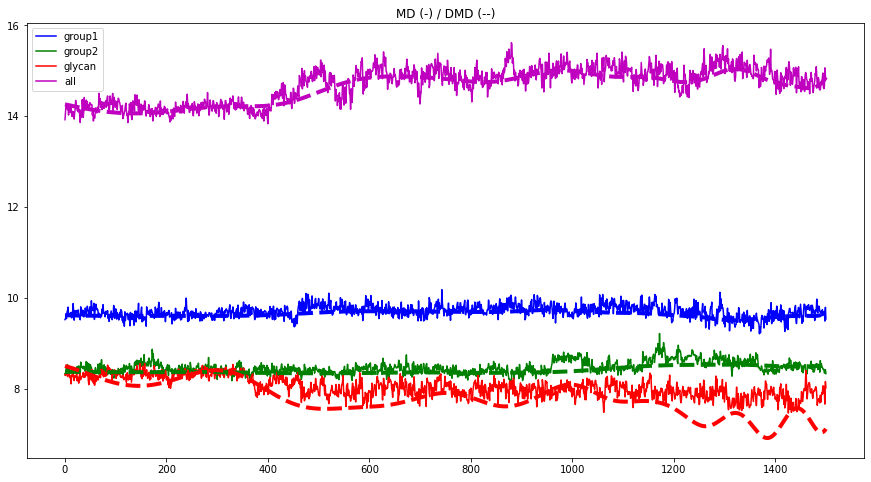

In [7]:
rog_dmd = {'group1':[],'group2':[],'glycan':[],'all':[]}
rog = {'group1':[],'group2':[],'glycan':[],'all':[]}
dict_domain = {'group1':'resid 4:15 or resid 34:45', 
               'group2': 'resid 104:117 or resid 170:176',
               'glycan':'resid 193:200',
               'all': 'resid 4:15 or resid 34:45 or resid 104:117 or resid 170:176 or resid 193:200'}
for key,value in dict_domain.items(): #Based on MDAnalysis script
    group_dmd = domain_dmd.select_atoms(value)
    group = u.select_atoms(value)
    for ntime in domain_dmd.trajectory:
        rog_dmd[key].append(group_dmd.atoms.radius_of_gyration())
    for ntime in u.trajectory:
        rog[key].append(group.atoms.radius_of_gyration())
    rog_dmd[key] = np.array(rog_dmd[key])
    rog[key] = np.array(rog[key])

fig, axs = plt.subplots(1, 1, figsize=(15,8))
axs.plot(range(len(rog['group1'])), rog['group1'],color='b',label='group1')
axs.plot(range(len(rog['group2'])), rog['group2'],color='g',label='group2')
axs.plot(range(len(rog['glycan'])), rog['glycan'],color='r',label='glycan')
axs.plot(range(len(rog['all'])), rog['all'],color='m',label='all')
axs.plot(range(len(rog_dmd['group1'])), rog_dmd['group1'],color='b',linestyle='--',linewidth=4)
axs.plot(range(len(rog_dmd['group2'])), rog_dmd['group2'],color='g',linestyle='--',linewidth=4)
axs.plot(range(len(rog_dmd['glycan'])), rog_dmd['glycan'],color='r',linestyle='--',linewidth=4)
axs.plot(range(len(rog_dmd['all'])), rog_dmd['all'],color='m',linestyle='--',linewidth=4)

axs.legend(); 
axs.set_title('MD (-) / DMD (--)'); 

Text(0.5, 0.98, 'Timestep -1')

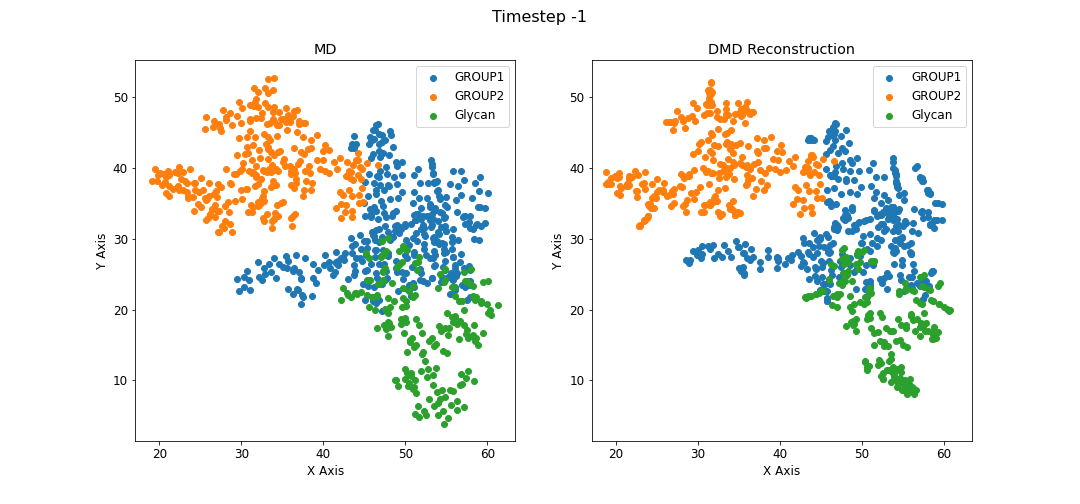

In [8]:
timestep = -1
nt = 1501 # 1501 timesteps
%matplotlib widget
X_traj_dmd = optdmd.reconstructed_data.reshape(len(domain),3,nt)
X_traj = X1.reshape(len(domain),3,nt) 
len_cut1 = len(domain_group1)
len_cut2 = len(domain_group1)+len(domain_group2)
rcParams['font.size'] = 12
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7))
ax1.scatter(np.real(X_traj[:len_cut1,0,timestep]),np.real(X_traj[:len_cut1,1,timestep]),label='GROUP1')
ax1.scatter(np.real(X_traj[len_cut1+1:len_cut2,0,timestep]),np.real(X_traj[len_cut1+1:len_cut2,1,timestep]),label='GROUP2')
ax1.scatter(np.real(X_traj[len_cut2+1:,0,timestep]),np.real(X_traj[len_cut2+1:,1,timestep]),label='Glycan')
ax1.set_title('MD'); ax1.set_xlabel('X Axis'); ax1.set_ylabel('Y Axis'); ax1.legend()

ax2.scatter(np.real(X_traj_dmd[:len_cut1,0,timestep]),np.real(X_traj_dmd[:len_cut1,1,timestep]),label='GROUP1')
ax2.scatter(np.real(X_traj_dmd[len_cut1+1:len_cut2,0,timestep]),np.real(X_traj_dmd[len_cut1+1:len_cut2,1,timestep]),label='GROUP2')
ax2.scatter(np.real(X_traj_dmd[len_cut2+1:,0,timestep]),np.real(X_traj_dmd[len_cut2+1:,1,timestep]),label='Glycan')
ax2.set_title('DMD Reconstruction'); ax2.set_xlabel('X Axis'); ax2.set_ylabel('Y Axis')
ax2.legend(); ax2.set_xlim(ax1.get_xlim()); ax2.set_ylim(ax1.get_ylim())

fig.suptitle(f'Timestep {timestep}', fontsize=16)